# MNIST Hyper Parameter Test

First, import modules

In [1]:
import numpy as np
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

Define transform functions for our train, test, and validation set. We also define our batch samplers

In [15]:
# Define subprocesses to use for data loading and samples per batch
num_workers = 0
batch_size = 20
valid_size = 0.2

# Define transform function to convert data to tensors
transform = transforms.ToTensor()

# Load training and test datasets
train_data = datasets.MNIST(root = 'data', train = True,
                            download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False,
                           download = True, transform = transform)

# Split data to training and validation sets
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

We view a sample size of our data.

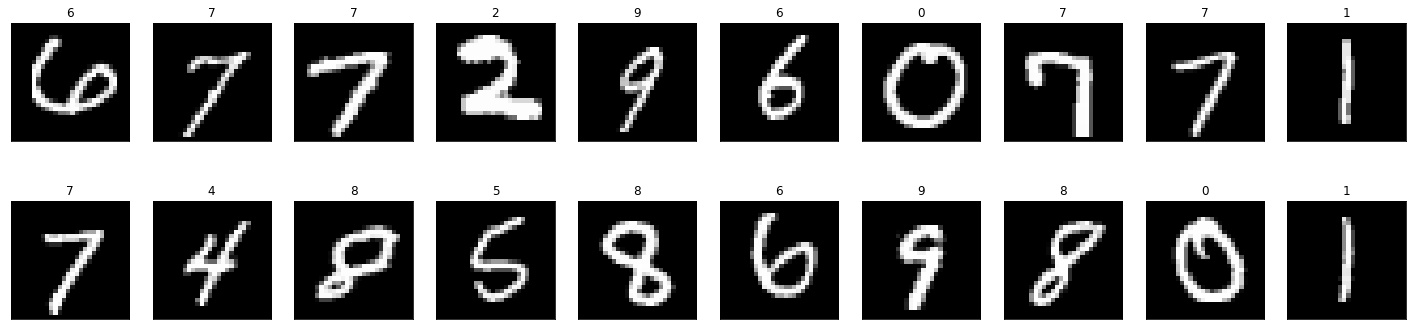

In [3]:
# Obtaining a batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Plot first batch of training image
# Define subplot sizes
fig = plt.figure(figsize = (25,6))
for idx in np.arange(batch_size):
    # Plot image and indicating position
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks = [], yticks = [])
    # Plot image
    ax.imshow(np.squeeze(images[idx]), cmap = 'gray')
    # Set correct label as title
    ax.set_title(str(labels[idx].item()))

We can also visualize the array in a heatmap.

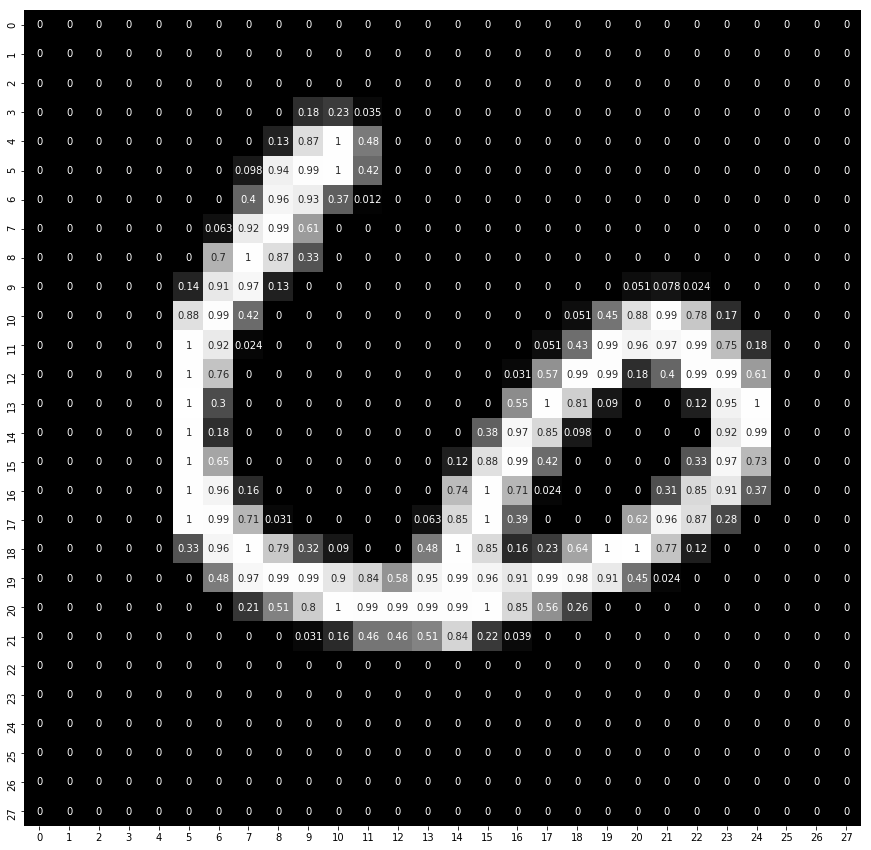

In [18]:
import seaborn as sns

ax = plt.figure(figsize = (15,15))
ax = sns.heatmap(np.squeeze(images[0]), cmap = 'gray',
                 annot = True, cbar = False)

Define the model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Linear layer
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten image
        x = x.view(-1, 28*28)
        # Pass to first hidden layer
        x = F.relu(self.fc1(x))
        # Dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # Pass to second hidden layer
        x = self.fc3(x)
        return x

Set model as our working model

In [6]:
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


Set the loss criterion and optimization process.

In [19]:
# Define loss and optimization process

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

Train the model!

In [10]:
# number of epochs to train the model
model.to('cuda')
n_epochs = 100

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf #Set initial loss to infinity

for epoch in range(n_epochs):
    
    train_loss = 0.00
    valid_loss = 0.00
    
    # Train sequence
    # Set model to train mode
    model.train()
    
    for data, target in train_loader:
        data, target = data.to('cuda'), target.to('cuda')
        # Zero out gradients
        optimizer.zero_grad()
        # Predict outputs
        output = model(data)
        # Calculate loss
        loss = criterion(output, target)
        # Perform back propagation
        loss.backward()
        # Perform optimization step
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)
        
    # Validation sequence
    # Set model to validation mode
    model.eval()
    
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        loss = criterion(output,target)
        valid_loss += loss.item() * data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(
           epoch+1,
           train_loss,
           valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). \t Saving model ...'.format(
              valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	 Training Loss: 0.010340 	 Validation Loss: 0.003815
Validation loss decreased (inf --> 0.003815). 	 Saving model ...
Epoch: 2 	 Training Loss: 0.009911 	 Validation Loss: 0.003509
Validation loss decreased (0.003815 --> 0.003509). 	 Saving model ...
Epoch: 3 	 Training Loss: 0.009259 	 Validation Loss: 0.003273
Validation loss decreased (0.003509 --> 0.003273). 	 Saving model ...
Epoch: 4 	 Training Loss: 0.009660 	 Validation Loss: 0.003041
Validation loss decreased (0.003273 --> 0.003041). 	 Saving model ...
Epoch: 5 	 Training Loss: 0.009165 	 Validation Loss: 0.003087
Epoch: 6 	 Training Loss: 0.008782 	 Validation Loss: 0.002898
Validation loss decreased (0.003041 --> 0.002898). 	 Saving model ...
Epoch: 7 	 Training Loss: 0.009104 	 Validation Loss: 0.002813
Validation loss decreased (0.002898 --> 0.002813). 	 Saving model ...
Epoch: 8 	 Training Loss: 0.008983 	 Validation Loss: 0.002615
Validation loss decreased (0.002813 --> 0.002615). 	 Saving model ...
Epoch: 9 	 

Validation loss decreased (0.000352 --> 0.000320). 	 Saving model ...
Epoch: 74 	 Training Loss: 0.002309 	 Validation Loss: 0.000346
Epoch: 75 	 Training Loss: 0.002236 	 Validation Loss: 0.000313
Validation loss decreased (0.000320 --> 0.000313). 	 Saving model ...
Epoch: 76 	 Training Loss: 0.001929 	 Validation Loss: 0.000291
Validation loss decreased (0.000313 --> 0.000291). 	 Saving model ...
Epoch: 77 	 Training Loss: 0.002171 	 Validation Loss: 0.000288
Validation loss decreased (0.000291 --> 0.000288). 	 Saving model ...
Epoch: 78 	 Training Loss: 0.002099 	 Validation Loss: 0.000319
Epoch: 79 	 Training Loss: 0.002244 	 Validation Loss: 0.000286
Validation loss decreased (0.000288 --> 0.000286). 	 Saving model ...
Epoch: 80 	 Training Loss: 0.002120 	 Validation Loss: 0.000325
Epoch: 81 	 Training Loss: 0.002196 	 Validation Loss: 0.000306
Epoch: 82 	 Training Loss: 0.001968 	 Validation Loss: 0.000266
Validation loss decreased (0.000286 --> 0.000266). 	 Saving model ...
Epoc

Save best model

In [13]:
model.load_state_dict(torch.load('model.pt'))

Check how it performs on the test set.

In [17]:
# initialize lists to monitor test loss and accuracy
model.to('cpu')
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # Predict outputs
    output = model(data)
    # Calculate loss
    loss = criterion(output, target)
    # Calculate test loss
    test_loss += loss.item()*data.size(0)
    # Return max prediction
    _, pred = torch.max(output, 1)
    # Compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.066962

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 97% (874/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 97% (949/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 98% (9836/10000)


With 100 epochs and 3 hidden layers, we've achieved an overall test accuracy of 98%